In [ ]:
%pip install folium fsspec geopandas mapclassify python-dotenv pystac-client shapely rasterio pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 10.2 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
from pathlib import Path
import json
import os
import requests
from dotenv import load_dotenv
from pystac_client import Client
from pystac.item import Item
from shapely.geometry import shape, Polygon, mapping
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import folium
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from pyproj import Transformer

#Store downloaded data in Google Drive
##Reminder: **please be careful with all the paths in this file and replace with your own ones**

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Example GeoJSON geometry
# Squamish - Garibaldi Lake
geojson_geometry = {
    # I drew a Polygon at geojson.io and put the contents of the `geometry` attribute here
    "type": "Polygon",
    "coordinates": [
        [
            [-123.11679830457658,49.96048123499753],
            [-123.11679830457658,49.89344994731354],
            [-122.98558891107739,49.89344994731354],
            [-122.98558891107739,49.96048123499753],
            [-123.11679830457658,49.96048123499753]
        ]
    ],
}

# Convert the GeoJSON geometry into a shapely geometry
shapely_geometry = shape(geojson_geometry)
# Create a GeoDataFrame with the shapely geometry
# Note that the Coordinate Reference System (CRS) defines how the two-dimensional,
# projected geometry relates to real world locations.
gdf = gpd.GeoDataFrame([{"geometry": shapely_geometry}], crs="EPSG:4326")

# Calculate the centroid of your GeoDataFrame to center the map
centroid = gdf.geometry.centroid.unary_union.centroid

# Create a folium map centered on the centroid of your shapefile
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=10)

# Add the GeoDataFrame as a layer to the folium map
folium.GeoJson(gdf, name="geojson").add_to(m)

# Add layer control to toggle the geojson layer
folium.LayerControl().add_to(m)

# Display the map
m

<ipython-input-3-8b974a246d66>:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid.unary_union.centroid


In [ ]:
load_dotenv(
    # You will need to create this file with your
    # CLIENT_ID, CLIENT_SECRET, AUTH_TOKEN_URL, and API_URL
    dotenv_path="secrets.env"
)
CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")
AUTH_TOKEN_URL = os.environ.get("AUTH_TOKEN_URL")
API_URL = os.environ.get("API_URL")


def get_new_token(client_id: str, client_secret: str, auth_token_url: str):
    """
    Authenticate with the Earth Platform and obtain a new access token.
    """
    token_req_payload = {"grant_type": "client_credentials"}
    token_response = requests.post(
        auth_token_url,
        data=token_req_payload,
        allow_redirects=False,
        auth=(client_id, client_secret),
    )
    token_response.raise_for_status()  # Raise an exception if the request failed

    tokens = json.loads(token_response.text)
    return tokens["access_token"]


token = get_new_token(CLIENT_ID, CLIENT_SECRET, AUTH_TOKEN_URL)
# Open a client to the STAC API
client = Client.open(API_URL, headers={"Authorization": f"Bearer {token}"})

In [ ]:
def get_sentinel2_data(
    client: Client,
    aoi: dict,
    start_date: str,
    end_date: str,
    cloud_cover: float = 1,
    max_items: int = 500,
):
    """
    Download Sentinel-2 data from the Earth Platform.
    """
    query = client.search(
        collections=["sentinel-2-l2a"],
        datetime=f"{start_date}T00:00:00.000000Z/{end_date}T00:00:00.000000Z",  # 2023-07-10T00:00:00.000000Z/2023-07-20T00:00:00.000000Z
        intersects=aoi,  # The area of interest; you can also query by bbox, or other geometry
        query={"eo:cloud_cover": {"lte": cloud_cover}},
        sortby=[
            {
                "field": "properties.eo:cloud_cover",
                "direction": "asc",
            },  # Sort by cloud cover from lowest to highest
        ],
        limit=max_items,  # This is the number of items to be returned per page
        max_items=max_items,  # This is number of items to page over
    )
    items = list(query.items())
    if len(items) == 0:
        raise Exception(
            "No items found, try enlarging search area or increasing cloud cover threshold."
        )
    print(f"Found: {len(items):d} tiles.")

    # Convert STAC items into a GeoJSON FeatureCollection
    stac_json = query.item_collection_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json, crs="EPSG:4326")

    return items, gdf

In [ ]:
start_date = "2019-06-01"  # June 1, 2019
end_date = "2019-08-15"  # August 15, 2019

sentinel_items, sentinel_gdf = get_sentinel2_data(
    client,
    shapely_geometry,
    start_date,
    end_date,
    cloud_cover=3,
    max_items=50,
)
print(f"Found {len(sentinel_items)} Sentinel-2 items/tiles.")

Found: 4 tiles.
Found 4 Sentinel-2 items/tiles.


In [ ]:
# Take a look at the tiles found for the given query on the map
sentinel_gdf.explore(color="green")

In [ ]:
# iterate through the tiles and plot them one by one on the map
# select the approriate tile that covers the entire area of interest
from IPython.display import display, HTML

def plot_tiles_one_by_one(gdf, map_center, zoom_start=10):
    for idx, row in gdf.iterrows():
        # Create a map centered around the specified location
        m = folium.Map(location=map_center, zoom_start=zoom_start)

        # Add the current tile to the map
        folium.GeoJson(row['geometry']).add_to(m)

        # Display the map
        display(m)

# Center the map around the centroid of the AOI or the first tile
map_center = sentinel_gdf.geometry[0].centroid.coords[0][::-1]  # (lat, lon) format

# Plot each tile one by one
plot_tiles_one_by_one(sentinel_gdf, map_center)

In [ ]:
# The items object contains a list of STAC items which includes
# metadata about the satellite imagery and links to the actual data.
# You can access the chosen item in the list by index:
sentinel_items[2]

<Item id=S2A_10UDA_20190807_0_L2A>

In [ ]:
# This cell creates utility functions to download the files associated with a STAC item to a local
# file system.

def download_file(href: str, outpath: Path):
    """
    Given a URL, download the file to the specified path.
    """
    with requests.get(href, stream=True) as r:
        r.raise_for_status()
        with open(outpath, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

def download_files_for_item(
    item: Item, asset_dict: dict[str, str], outpath: Path, debug: bool = True
) -> bool:
    """
    Save all files of interest for a given item.

    If one file fails to download return False, otherwise return True.
    """
    if not outpath.exists():
        outpath.mkdir(exist_ok=True, parents=True)

    for key, value in asset_dict.items():
        if debug:
          print(f"Downloading {key} and relabeling to {value}")
        if key in item.assets:
            if key in ["tileinfo_metadata"]:
                file_outpath = outpath / f"{value}.json"
            else:
                file_outpath = outpath / f"{value}.tiff"
            if not file_outpath.exists():
                try:
                    download_file(item.assets[key].href, file_outpath)
                except requests.ConnectionError:
                    print(
                        f"Failed to download {item.assets[key].href} for item {item.id}"
                    )
                    return False
                except requests.exceptions.ReadTimeout:
                    print(
                        f"Experienced a read timeout for {item.assets[key].href} for item {item.id}"
                    )
                    return False
            else:
                print(f"Skipping {item.assets[key].href} as it already exists.")

    return True

In [ ]:
high_resolution_bands = {"red": "B04", "green": "B03", "blue": "B02", "nir": "B08"}
mid_resolution_bands = {
    "rededge1": "B05",
    "rededge2": "B06",
    "rededge3": "B07",
    "nir08": "B8A",
    "swir16": "B11",
    "swir22": "B12",
}
all_download_files = { # Modify this variable to change the files that are downloaded
    **high_resolution_bands,
    **mid_resolution_bands,
}

In [ ]:
def download_and_tile_files(items: list[Item], download_files: dict[str, str], output_dir: Path):
    """
    Given a GeoDataFrame of items and a list of STAC items, download the
    files to a given output directory.

    Parameters:
      items: A list of items that correspond to tiles found in the GeoDataFrame and include paths to files to be
        downloaded in this function.
      download_files: A dictionary of strings where the keys correspond to names of items on the Earth Platform
        and the values correspond to their Sentinel-2 name.
    """
    downloaded = 0
    for index, tile in enumerate(items):
        dt_obj = datetime.strptime(tile.properties["datetime"], "%Y-%m-%dT%H:%M:%S.%fZ")
        formatted_date = dt_obj.strftime("%Y%m%d")
        out_path = output_dir / tile.id / formatted_date
        downloaded = download_files_for_item(tile, download_files, out_path)

        if downloaded:
            downloaded += 1
        else:
            print(f"Unable to download file for item with id: {tile.id} at index: {index} in items list.")

    print(
        f"Downloaded all bands for {downloaded} tiles. Failed to download at least one "
        + f"band or file for {len(items) - downloaded} tiles."
    )

In [ ]:
output_dir = Path("/content/drive/MyDrive/gari") # Used for Google CoLab

# We are only going to download 2 tiles here, but feel free to modify this function
# call to download more data!
download_and_tile_files(sentinel_items[0:3], all_download_files, output_dir)

Downloaded all bands for 2 tiles. Failed to download at least one band or file for 1 tiles.


In [ ]:
# crop the tile to locate the aoi

# Define the bounding box coordinates in latitude and longitude
polygon_coords = [
    (-123.11679830457658, 49.96048123499753),
    (-123.11679830457658, 49.89344994731354),
    (-122.98558891107739, 49.89344994731354),
    (-122.98558891107739, 49.96048123499753),
    (-123.11679830457658, 49.96048123499753)  # Closing the polygon
]

# Convert the polygon coordinates to the image's CRS
def convert_coords(coords, transformer):
    return [transformer.transform(lon, lat) for lon, lat in coords]

# Directory containing the .tiff files (update with your input path)
input_directory = '/content/drive/MyDrive/gari/S2A_10UDA_20190807_0_L2A/20190807'

# Directory to save the cropped .tiff files
output_directory = '/content/drive/MyDrive/gari/cropped'

# Ensure output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List of bands to crop
bands = [
    "B02.tiff", "B03.tiff", "B04.tiff", "B05.tiff", "B06.tiff", "B07.tiff",
    "B08.tiff", "B11.tiff", "B12.tiff", "B8A.tiff",
]

for band in bands:
    input_path = os.path.join(input_directory, band)
    output_path = os.path.join(output_directory, band)

    with rasterio.open(input_path) as src:
        # Get the CRS of the image
        image_crs = src.crs

        # Create a transformer to convert from latitude/longitude to the image's CRS
        transformer = Transformer.from_crs("EPSG:4326", image_crs, always_xy=True)

        # Convert the polygon coordinates
        transformed_coords = convert_coords(polygon_coords, transformer)

        # Create a polygon
        polygon = Polygon(transformed_coords)
        geojson_polygon = [mapping(polygon)]

        # Mask and crop the image using the polygon
        out_image, out_transform = mask(src, geojson_polygon, crop=True)

        # Update the metadata to reflect the new dimensions and transform
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Write the cropped data to a new file
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

print("Cropping complete!")

Cropping complete!


In [ ]:
def display_images(image_dict):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 1, 1 for test
    fig.tight_layout()

    for i, (title, image) in enumerate(image_dict.items()):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(image)
        axes[row, col].set_title(title)
        axes[row, col].axis("off")

    plt.show()

def brighten(band: np.ndarray):
    """Adjust image brightness using an alpha value (0 to 1). Higher alpha increases brightness, lower decreases."""

    alpha=0.2 # you can change this value
    beta=0
    return np.clip(alpha*band+beta, 0,255)

def normalize(band: np.ndarray) -> np.ndarray:
    """
    First brighten the bands and then return normalized image
    """
    band = brighten(band)
    band_min, band_max = (band.min(), band.max())

    return ((band-band_min)/((band_max - band_min)))

def display_transformed_images(data_path: Path):
    """
    Generate Sentinel-2 images from the given filepath. The returned images are as follows:
       NDVI: Normalized Difference Vegetation Index
       NDVI705: Normalized Difference Vegetation Index (705m)
       NDBI: Normalized Difference Built-up Index
       NDWI: Normalized Difference Water Index
       False Color: B08, B04, B03
       Mask: The class labels for each pixel

    Please Note: If the size of the input

    Note: If the input tile contains 0 values (ie. black squares in the tiles),
      a warning will be printed due to division by zero.
    """
    # Unpack the bands
    band_size = tiff.imread(f"{data_path}/B02.tiff").shape
    print(band_size)

    B02 = normalize(
            tiff.imread(f"{data_path}/B02.tiff"),)
    B03 = normalize(
            tiff.imread(f"{data_path}/B03.tiff"),)
    B04 = normalize(
            tiff.imread(f"{data_path}/B04.tiff"),)
    B05 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B05.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))
    B08 = normalize(
            tiff.imread(f"{data_path}/B08.tiff"),)

    B11 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B11.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))

    B12 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B12.tiff"),
                band_size[::-1]
            ))

    # Calculate NDVI (Normalized Difference Vegetation Index)
    NDVI = (B08 - B04) / (B08 + B04)

    # Calculate NDVI705
    NDVI705 = (B05 - B04) / (B05 + B04)

    # Calculate NDBI (Normalized Difference Built-Up Index)
    NDBI = (B11 - B08) / (B11 + B08)

    # # Calculate NDWI (Normalized Difference Water Index)
    NDWI = (B08 - B12) / (B08 + B12)

    # # Calculate NBR (Normalized Burn Ratio)
    NBR = (B08 - B12) / (B08 + B12)

    # Create a color image using RGB bands
    RGB = np.stack([B04, B03, B02], axis=-1)
    # save the RGB image to Google Drive
    # Normalize the image to the range [0, 255] and convert to uint8
    RGB_normalized = (255 * (RGB / RGB.max())).astype(np.uint8)
    save_path = '/content/drive/MyDrive/gari/cropped/gari_RGB.png'
    cv2.imwrite(save_path, cv2.cvtColor(RGB_normalized, cv2.COLOR_RGB2BGR))

    # Create a false-color composite image
    # false_color = np.stack([B08, B04, B03], axis=-1)


    images = {
        "NDVI": NDVI,
        "NDVI705": NDVI705,
        "NDBI": NDBI,
        "NDWI": NDWI,
        "NBR": NBR,
        "RGB": RGB,
        # "False Color": false_color,
    }

    display_images(images)

    return images

(747, 943)


<ipython-input-18-38ef0e193709>:76: RuntimeWarning: invalid value encountered in divide
  NDVI = (B08 - B04) / (B08 + B04)
<ipython-input-18-38ef0e193709>:79: RuntimeWarning: invalid value encountered in divide
  NDVI705 = (B05 - B04) / (B05 + B04)
<ipython-input-18-38ef0e193709>:82: RuntimeWarning: invalid value encountered in divide
  NDBI = (B11 - B08) / (B11 + B08)
<ipython-input-18-38ef0e193709>:85: RuntimeWarning: invalid value encountered in divide
  NDWI = (B08 - B12) / (B08 + B12)
<ipython-input-18-38ef0e193709>:88: RuntimeWarning: invalid value encountered in divide
  NBR = (B08 - B12) / (B08 + B12)


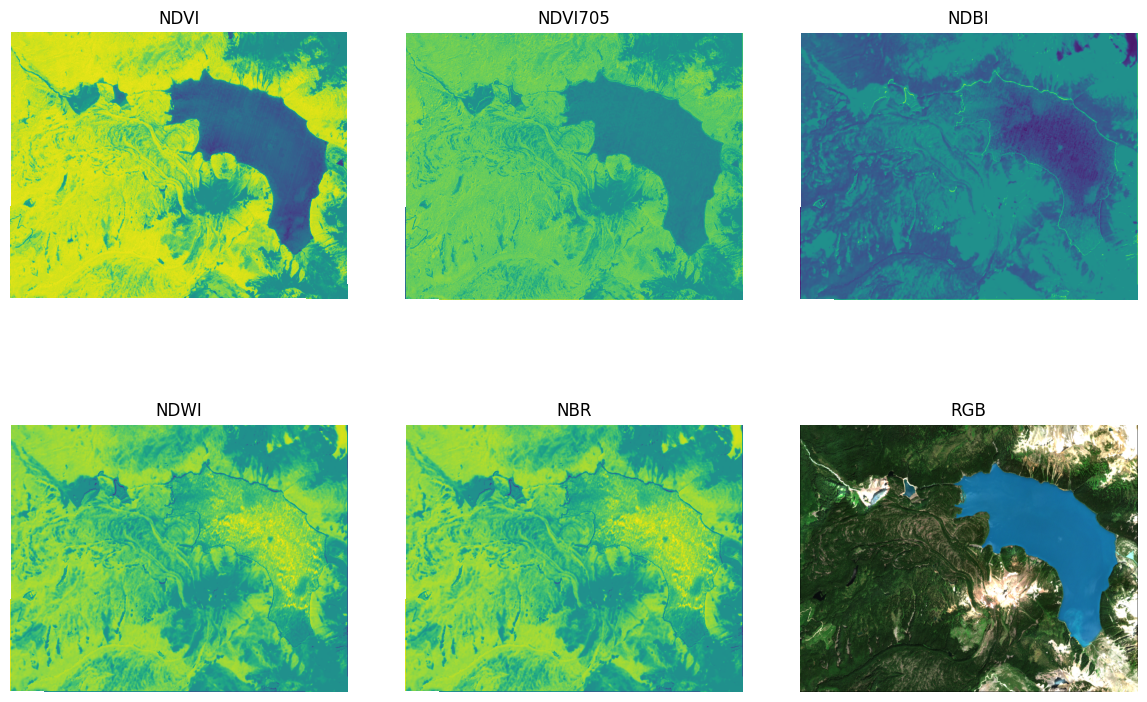

In [ ]:
cropped_tile_path = "/content/drive/MyDrive/gari/cropped"  # TODO put the path to the tile here

images = display_transformed_images(cropped_tile_path)

#Ground Truth Download code at [Google Earth Engine](https://code.earthengine.google.com/?scriptPath=users%2Fsat-io%2Fawesome-gee-catalog-examples%3Aagriculture-vegetation-forestry%2FCA-FORESTED-ECOSYSTEM-LC)

In [ ]:
# Ground truth download
var ca_lc_last = ee.Image(ca_lc.sort('system:time_start',false).first());

var from = [0, 20, 31, 32, 33, 40, 50, 80, 81, 100, 210, 220, 230];
var to =   [0, 1,  2,  3,  4,  5,  6,  7,  8,  9,   10,  11,  12 ];
ca_lc_last = ca_lc_last.remap(from, to);

print("Reclassed values:");
print({"from": from, "to": to});

// Define a dictionary which will be used to make legend and visualize image on map
var dict = {
  "names": [
  "Unclassified",
  "Water",
  "Snow/Ice",
  "Rock/Rubble",
  "Exposed/Barren land",
  "Bryoids",
  "Shrubs",
  "Wetland",
  "Wetland-treed",
  "Herbs",
  "Coniferous",
  "Broadleaf",
  "Mixedwood"
  ],
  "colors": [
    "#686868",
    "#3333ff",
    "#ccffff",
    "#cccccc",
    "#996633",
    "#ffccff",
    "#ffff00",
    "#993399",
    "#9933cc",
    "#ccff33",
    "#006600",
    "#00cc00",
    "#cc9900"
  ]};

// Create a panel to hold the legend widget
var legend = ui.Panel({
  style: {
    position: 'bottom-left',
    padding: '8px 15px'
  }
});

// Function to generate the legend
function addCategoricalLegend(panel, dict, title) {

  // Create and add the legend title.
  var legendTitle = ui.Label({
    value: title,
    style: {
      fontWeight: 'bold',
      fontSize: '18px',
      margin: '0 0 4px 0',
      padding: '0'
    }
  });
  panel.add(legendTitle);

  var loading = ui.Label('Loading legend...', {margin: '2px 0 4px 0'});
  panel.add(loading);

  // Creates and styles 1 row of the legend.
  var makeRow = function(color, name) {
    // Create the label that is actually the colored box.
    var colorBox = ui.Label({
      style: {
        backgroundColor: color,
        // Use padding to give the box height and width.
        padding: '8px',
        margin: '0 0 4px 0'
      }
    });

    // Create the label filled with the description text.
    var description = ui.Label({
      value: name,
      style: {margin: '0 0 4px 6px'}
    });

    return ui.Panel({
      widgets: [colorBox, description],
      layout: ui.Panel.Layout.Flow('horizontal')
    });
  };

  // Get the list of palette colors and class names from the image.
  var palette = dict['colors'];
  var names = dict['names'];
  loading.style().set('shown', false);

  for (var i = 0; i < names.length; i++) {
    panel.add(makeRow(palette[i], names[i]));
  }

  Map.add(panel);

}


/*
  // Display map and legend ///////////////////////////////////////////////////////////////////////////////
*/

// Add the legend to the map
addCategoricalLegend(legend, dict, 'CA Annual forest LC map 2019');

Map.setCenter(-97.61655457157725,55.6280720462063,4)

// Add image to the map
Map.addLayer(ca_lc_last.mask(ca_lc_last.neq(0)), {min:0, max:12, palette:dict['colors']}, 'CA Annual forest LC map 2019')

// Add a RGB layer
// Define the visualization parameters with the color palette
var visualization = {
  min: 0,
  max: 12,
  palette: [
    "#686868", "#3333ff", "#ccffff", "#cccccc", "#996633",
    "#ffccff", "#ffff00", "#993399", "#9933cc", "#ccff33",
    "#006600", "#00cc00", "#cc9900"
  ]
};

// Apply the visualization parameters
var visualizedImage = ca_lc_last.visualize(visualization);

// Display the RGB image on the map
Map.addLayer(visualizedImage, {}, 'CA Annual Forest LC Map 2019 RGB');

// Download a specific area
var geojsonGeometry = {
  "type": "Polygon",
  "coordinates": [
    [
      [-123.11679830457658,49.96048123499753],
      [-123.11679830457658,49.89344994731354],
      [-122.98558891107739,49.89344994731354],
      [-122.98558891107739,49.96048123499753],
    ]
  ]
};

// Create an Earth Engine geometry object using GeoJSON
var region = ee.Geometry(geojsonGeometry);

Map.centerObject(region, 15); // Center the map on this area at a higher zoom level
Map.addLayer(region, {color: 'red'}, 'Custom Polygon Region');

// Export the RGB image
Export.image.toDrive({
  image: visualizedImage,
  description: 'garibaldi_lake_RGB',
  scale: 30,
  region: region,  // Use the defined polygon area
  formatOptions: {
    cloudOptimized: true
  }
});